# Libraries

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

# Dataset preprocessing

In [20]:
df = pd.read_csv("test_steven_temporal.csv")
df.head()

,User ID,Sample ID,Date Created,Date changed,Sample Date,year,month,1Spring/2Autumn,which.blitz,Group ID,...,Longitude),Total number of participants,Notes,Freshwater body type,Other,What is the land use in the immediate surroundings?,What is the bank vegetation? (select all that apply),Is there any of the following on the water surface?,Nitrate,Phosphate
0,14663,19524,18/01/2018 17:45,18/01/2018 17:45,10/06/2015 08:34,2015,6,1,1,"Thames Blitz, Group ID: 34343",...,-1.076161,27.0,The Year 4 class helped with the Totally Thame...,River,NaN,NaN,NaN,NaN,0.1,0.010
1,14117,18161,18/01/2018 17:45,18/01/2018 17:45,14/09/2015 00:00,2015,9,2,1,"Thames Blitz, Group ID: 34343",...,-1.565350,1.0,NaN,Stream,NaN,NaN,NaN,NaN,12.0,0.075
2,14117,18165,18/01/2018 17:45,18/01/2018 17:45,14/09/2015 00:00,2015,9,2,1,"Thames Blitz, Group ID: 34343",...,-1.674520,1.0,NaN,River,NaN,NaN,NaN,NaN,12.0,0.075
3,14019,18168,18/01/2018 17:45,18/01/2018 17:45,14/09/2015 07:45,2015,9,2,1,"Thames Blitz, Group ID: 34343",...,-1.656125,1.0,House about 200 yards above it. Uncultivated g...,Stream,NaN,NaN,NaN,NaN,7.5,0.150
4,14019,18169,18/01/2018 17:45,18/01/2018 17:45,14/09/2015 07:55,2015,9,2,1,"Thames Blitz, Group ID: 34343",...,-1.657519,1.0,signs of cows in and around stream,Stream,NaN,NaN,NaN,NaN,7.5,0.010


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2361 entries, 0 to 2360
Data columns (total 23 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   User ID                                               2361 non-null   int64  
 1   Sample ID                                             2361 non-null   int64  
 2   Date Created                                          2361 non-null   object 
 3   Date changed                                          2361 non-null   object 
 4   Sample Date                                           2361 non-null   object 
 5   year                                                  2361 non-null   int64  
 6   month                                                 2361 non-null   int64  
 7   1Spring/2Autumn                                       2361 non-null   int64  
 8   which.blitz                                           2351

In [22]:
# using Temporal input data to predict Nitrate concentration
df_final = df[["Phosphate","year","month","1Spring/2Autumn"]]

In [23]:
# Converting all columns to float
df_final = df_final.astype(float)

In [24]:
df_final.dtypes

Phosphate          float64
year               float64
month              float64
1Spring/2Autumn    float64
dtype: object

In [25]:
df_final.isnull().values.any()

False

In [26]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2361 entries, 0 to 2360
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Phosphate        2361 non-null   float64
 1   year             2361 non-null   float64
 2   month            2361 non-null   float64
 3   1Spring/2Autumn  2361 non-null   float64
dtypes: float64(4)
memory usage: 73.9 KB


# Creating basic NN class for pytorch

In [27]:
class Model(nn.Module):
    
    def __init__(self, in_features=3, h1=30,h2=60,h3=120,h4=240, out_features=2361):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)
        self.fc2 = nn.Linear(h1,h2)
        self.fc3 = nn.Linear(h2,h3)
        self.fc4 = nn.Linear(h3,h4)
        self.out = nn.Linear(h4,out_features)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.out(x)
        
        return x

In [28]:
# seeding NN with 96

torch.manual_seed(96)

model = Model()

# Train Test Split by setting X,y

In [29]:
# X = features
# y = output

X = df_final.drop("Phosphate",axis=1)
y = df_final["Phosphate"]

In [30]:
# Converting to numpy arrays

X = X.values
y = y.values

In [31]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=96)

In [32]:
# Convert numpy arrays to tensors

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

###### Setting Criteria NN model  error + setting the optimizer + Learning Rate

In [33]:
# Set criteria NN to measure the error
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam) and learning rate

optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

# Training model 

In [34]:
# Training our model
# first set epochs = 100

epochs = 1000
losses = []

for i in range(epochs):
    # Going forward and getting a prediction
    y_pred =model.forward(X_train)
    
    # Measuring the loss/error
    
    # predicted values vs the y_train values
    loss = criterion(y_pred, y_train)
    
    # Keep Track of our losses
    
    losses.append(loss.detach().numpy())
    
    # print every 10 epochs
    
    if i % 10 == 0:
        print(f"Epoch: {i} and loss: {loss}")
        
    # Taking error rate and feed it back to model through NN 
    # for fine tuning of the rates (back propagation)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 0 and loss: 55.65462112426758
Epoch: 10 and loss: 7.465333461761475
Epoch: 20 and loss: 10.371743202209473
Epoch: 30 and loss: 4.041754722595215
Epoch: 40 and loss: 5.616658687591553
Epoch: 50 and loss: 3.5879645347595215
Epoch: 60 and loss: 3.4816882610321045
Epoch: 70 and loss: 0.19479162991046906
Epoch: 80 and loss: 0.1900983601808548
Epoch: 90 and loss: 0.13379181921482086
Epoch: 100 and loss: 0.11567829549312592
Epoch: 110 and loss: 0.10986141115427017
Epoch: 120 and loss: 0.10771021246910095
Epoch: 130 and loss: 0.1069258525967598
Epoch: 140 and loss: 0.10671240836381912
Epoch: 150 and loss: 0.10665743052959442
Epoch: 160 and loss: 0.10665581375360489
Epoch: 170 and loss: 0.10665822774171829
Epoch: 180 and loss: 0.1066572368144989
Epoch: 190 and loss: 0.10665576159954071
Epoch: 200 and loss: 0.10665512830018997
Epoch: 210 and loss: 0.10665503144264221
Epoch: 220 and loss: 0.10665503889322281
Epoch: 230 and loss: 0.10665503144264221
Epoch: 240 and loss: 0.10665508359670639


# Graphs using matplotlib

Text(0, 0.5, 'loss')

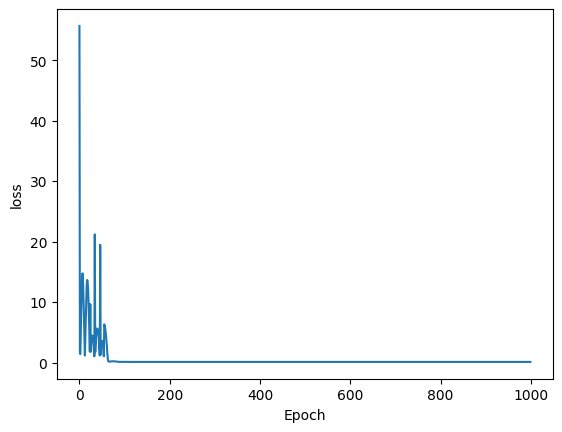

In [35]:
plt.plot(range(epochs),losses)
plt.xlabel("Epoch")
plt.ylabel("loss")

In [38]:
# Evaluating Model on Test Data set (validating model on test data)

# turning off back propagation on test

with torch.no_grad():
    # X_test are features from the test
    # y_eval will be the predictions
    y_eval = model.forward(X_test)
    
    # Find the loss or error
    loss = criterion(y_eval, y_test)


In [39]:
# loss in test data and training matches test value
# model seems to be performing quiet well

loss

tensor(0.1025)

In [40]:
# Evaluating how the test data set performed

correct = 0

with torch.no_grad():
    for i, data in enumerate(X_test):
        y_val = model.forward(data)
        
        
        # This will tell us what the Phosphate concentration is  
        # using temporal data from our NN
        print(f"{i+1}.) {str(y_val)} \t {y_test[i]} \t {y_val.argmax().item()} ")
        
        
        # Correct or not
        
        if y_val.argmax().item() == y_test[i]:
            correct +=1
            
    print(f"We got {correct} correct!")

1.) tensor([ 11.0308,   7.2477, -32.9068,  ..., -32.4957, -31.2401, -30.8666]) 	 0 	 0 
2.) tensor([ 11.0308,   7.2477, -32.9068,  ..., -32.4957, -31.2401, -30.8666]) 	 0 	 0 
3.) tensor([ 11.0308,   7.2477, -32.9068,  ..., -32.4957, -31.2401, -30.8666]) 	 0 	 0 
4.) tensor([ 11.0308,   7.2477, -32.9068,  ..., -32.4957, -31.2401, -30.8666]) 	 0 	 0 
5.) tensor([ 11.0308,   7.2477, -32.9068,  ..., -32.4957, -31.2401, -30.8666]) 	 0 	 0 
6.) tensor([ 11.0308,   7.2477, -32.9068,  ..., -32.4957, -31.2401, -30.8666]) 	 0 	 0 
7.) tensor([ 11.0308,   7.2477, -32.9068,  ..., -32.4957, -31.2401, -30.8666]) 	 0 	 0 
8.) tensor([ 11.0308,   7.2477, -32.9068,  ..., -32.4957, -31.2401, -30.8666]) 	 0 	 0 
9.) tensor([ 11.0308,   7.2477, -32.9068,  ..., -32.4957, -31.2401, -30.8666]) 	 1 	 0 
10.) tensor([ 11.0308,   7.2477, -32.9068,  ..., -32.4957, -31.2401, -30.8666]) 	 0 	 0 
11.) tensor([ 11.0308,   7.2477, -32.9068,  ..., -32.4957, -31.2401, -30.8666]) 	 0 	 0 
12.) tensor([ 11.0308,   7.247